<a href="https://colab.research.google.com/github/abcdefg-666/python_policy_final_project/blob/main/Python_for_Public_Policy_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# simplest Moving Average Strategy  （with 50，100 fixed strategy）

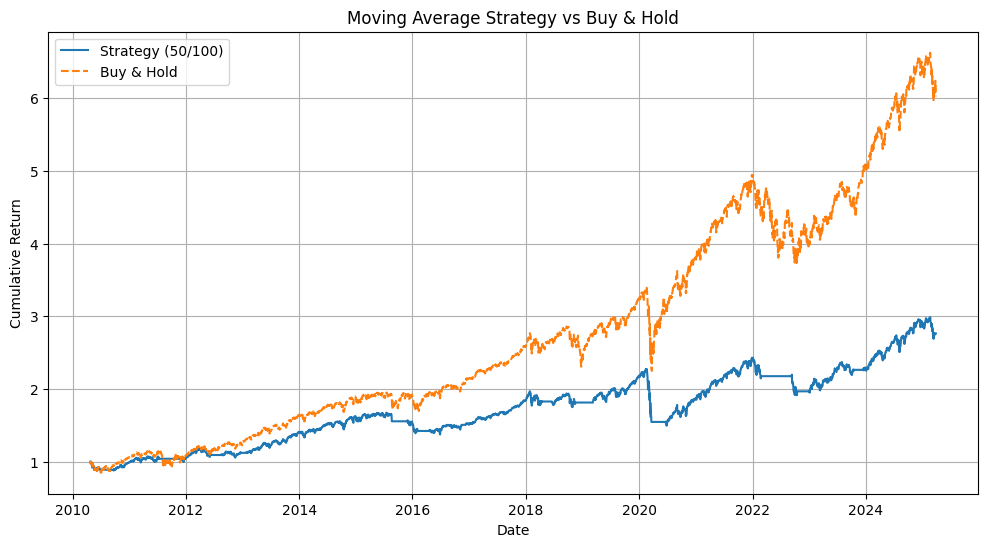

Performance for MA(50,100):
{'total_return': np.float64(1.7632226619546754), 'annual_return': np.float64(0.0705717078851773), 'annual_vol': np.float64(0.13398323801870116), 'sharpe': np.float64(0.5267204236049813), 'max_drawdown': 0.3435830258854847, 'calmar': np.float64(0.20539928508778738)}


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === Read data ===
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SPY_Historical_Data.csv', parse_dates=['Date'], index_col='Date')
df = df.sort_index()
df = df[['Adj Close']]

# === Define MA strategy function ===
def moving_average_strategy(df, short_w, long_w, fee=0.001):
    data = df.copy()
    data['short_ma'] = data['Adj Close'].rolling(short_w).mean()
    data['long_ma']  = data['Adj Close'].rolling(long_w).mean()
    data['signal']   = (data['short_ma'] > data['long_ma']).astype(int)
    data['trade']    = data['signal'].diff().fillna(0)

    # Position Management
    data['position'] = 0
    for i in range(1, len(data)):
        if data['signal'].iat[i] == 1:
            data['position'].iat[i] = 1
        elif data['signal'].iat[i] == 0 and data['position'].iat[i-1] == 1:
            data['position'].iat[i] = 0
        else:
            data['position'].iat[i] = data['position'].iat[i-1]

    # Strategy profit calculation
    data['ret'] = data['Adj Close'].pct_change() * data['position'].shift(1)
    data['ret'] -= abs(data['trade']) * fee
    data.dropna(inplace=True)
    data['cum_ret'] = (1 + data['ret']).cumprod()
    return data

# === Fixed parameters ===
short_w = 50
long_w = 100

# === Execution strategy ===
result = moving_average_strategy(df, short_w, long_w)

# === Visualizing the Yield Curve ===
plt.figure(figsize=(12,6))
plt.plot(result.index, result['cum_ret'], label='Strategy (50/100)')
plt.plot(result.index, result['Adj Close']/result['Adj Close'].iloc[0], '--', label='Buy & Hold')
plt.title('Moving Average Strategy vs Buy & Hold')
plt.xlabel('Date'); plt.ylabel('Cumulative Return')
plt.legend(); plt.grid(); plt.show()

# === Performance evaluation function ===
def performance_stats(res):
    total_return = res['cum_ret'].iloc[-1] - 1
    annual_return = np.exp(np.log1p(res['ret']).sum()/len(res) * 252) - 1
    annual_vol = res['ret'].std() * np.sqrt(252)
    sharpe = annual_return / annual_vol if annual_vol != 0 else np.nan
    drawdown = (res['cum_ret'].cummax() - res['cum_ret']) / res['cum_ret'].cummax()
    max_dd = drawdown.max()
    calmar = annual_return / max_dd if max_dd != 0 else np.nan
    return {
        'total_return': total_return,
        'annual_return': annual_return,
        'annual_vol': annual_vol,
        'sharpe': sharpe,
        'max_drawdown': max_dd,
        'calmar': calmar
    }

# === Output performance indicators ===
stats = performance_stats(result)
print(f"Performance for MA(50,100):\n{stats}")



# The most basic: MA + grid search+walk forward cv

    short  long  ann_return    sharpe  max_drawdown
14      7   200    0.102823  0.856564      0.182717
19     10   200    0.101184  0.824789      0.182717
9       5   200    0.098359  0.811470      0.182717
8       5   150    0.089555  0.763038      0.182717
24     15   200    0.096553  0.752953      0.182717
3       3   150    0.085139  0.732110      0.182717
17     10   100    0.083654  0.714924      0.182717
13      7   150    0.081923  0.695882      0.182717
29     20   200    0.091451  0.681511      0.182717
33     30   200    0.092520  0.681354      0.182717
12      7   100    0.078366  0.674610      0.182717
18     10   150    0.077468  0.645429      0.182717
32     30   150    0.085485  0.644281      0.182717
28     20   150    0.081512  0.642342      0.182717
23     15   150    0.078451  0.637107      0.182717
7       5   100    0.072734  0.631796      0.182717
4       3   200    0.075882  0.629415      0.182717
2       3   100    0.066234  0.582017      0.182717
16     10   

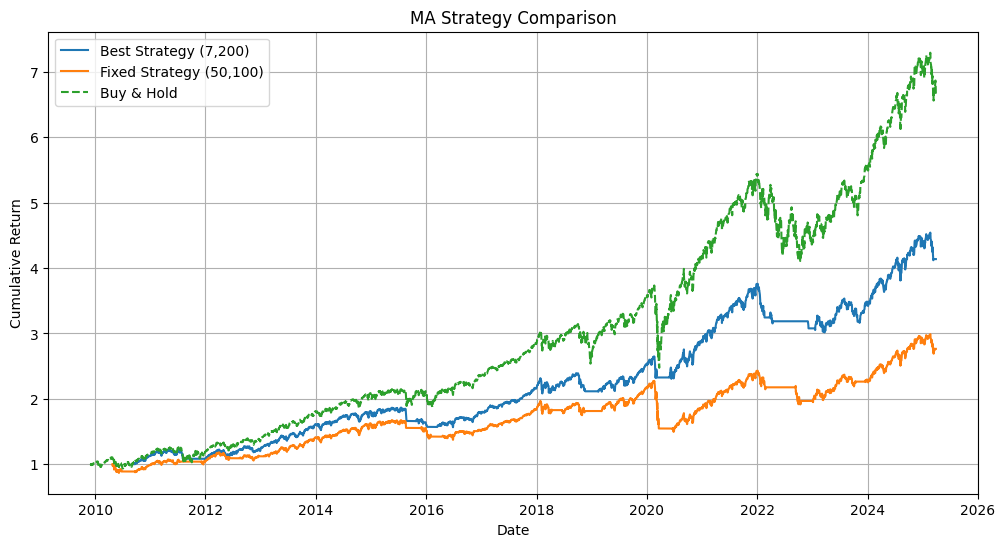

Best Strategy Stats:
{'total_return': np.float64(3.136870530436397), 'annual_return': np.float64(0.1028230462385109), 'annual_vol': np.float64(0.12004122543040681), 'sharpe': np.float64(0.8565644500032362), 'max_drawdown': 0.19791473195597492, 'calmar': np.float64(0.5195320490916429)}

Fixed Strategy (50,100) Stats:
{'total_return': np.float64(1.7632226619546754), 'annual_return': np.float64(0.0705717078851773), 'annual_vol': np.float64(0.13398323801870116), 'sharpe': np.float64(0.5267204236049813), 'max_drawdown': 0.3435830258854847, 'calmar': np.float64(0.20539928508778738)}


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

# === Read data ===
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SPY_Historical_Data.csv', parse_dates=['Date'], index_col='Date')
df = df.sort_index()
df = df[['Adj Close']]


def moving_average_strategy(df, short_w, long_w, fee=0.001):
    data = df.copy()
    data['short_ma'] = data['Adj Close'].rolling(short_w).mean()
    data['long_ma']  = data['Adj Close'].rolling(long_w).mean()
    data['signal']   = (data['short_ma'] > data['long_ma']).astype(int)
    data['trade']    = data['signal'].diff().fillna(0)
    data['position'] = data['signal']

# === Revenue calculation ===
    data['ret'] = data['Adj Close'].pct_change() * data['position'].shift(1)
    data['ret'] -= abs(data['trade']) * fee
    data.dropna(inplace=True)
    data['cum_ret'] = (1 + data['ret']).cumprod()
    return data

# === Parameter interval setting ===
short_windows = [3,5,7,10,15,20,30]
long_windows = [30,50,100,150,200]

results = []

for short, long in product(short_windows, long_windows):
    if short >= long:
        continue  # Short term cannot be equal to or greater than long term
    res = moving_average_strategy(df, short, long)

    ann_ret = np.exp(np.log1p(res['ret']).sum()/len(res) * 252) - 1
    ann_vol = res['ret'].std() * np.sqrt(252)
    sharpe = ann_ret / ann_vol if ann_vol != 0 else np.nan
    max_dd = (res['Adj Close'].cummax() - res['Adj Close']).max() / res['Adj Close'].cummax().max()
    results.append({
        'short': short,
        'long': long,
        'ann_return': ann_ret,
        'sharpe': sharpe,
        'max_drawdown': max_dd
    })

results_df = pd.DataFrame(results)
print(results_df.sort_values('sharpe', ascending=False))


# === Select the optimal parameters
best_row = results_df.sort_values('sharpe', ascending=False).iloc[0]
best_short = best_row['short']
best_long = best_row['long']

print("best short:")
print(best_short, type(best_short))
print("best long:")
print(best_long, type(best_long))

# === Get the optimal parameters and force them to be integers ===
best_row = results_df.sort_values('sharpe', ascending=False).iloc[0]
best_short = int(best_row['short'])
best_long = int(best_row['long'])


# === Backtesting the optimal parameter strategy ===
best_result = moving_average_strategy(df, best_short, best_long)
best_result['cum_ret'] = (1 + best_result['ret']).cumprod()

# === Backtest fixed parameter strategy (50,100）===
fixed_result = moving_average_strategy(df, short_w=50, long_w=100)
fixed_result['cum_ret'] = (1 + fixed_result['ret']).cumprod()

# === visualization ===
plt.figure(figsize=(12,6))
plt.plot(best_result.index, best_result['cum_ret'], label=f'Best Strategy ({best_short},{best_long})')
plt.plot(fixed_result.index, fixed_result['cum_ret'], label='Fixed Strategy (50,100)')
plt.plot(df.index, df['Adj Close'] / df['Adj Close'].iloc[0], '--', label='Buy & Hold')
plt.title('MA Strategy Comparison')
plt.xlabel('Date'); plt.ylabel('Cumulative Return')
plt.legend(); plt.grid(); plt.show()

# === Output performance indicators ===
def performance_stats(res):
    total_return = res['cum_ret'].iloc[-1] - 1
    annual_return = np.exp(np.log1p(res['ret']).sum()/len(res) * 252) - 1
    annual_vol = res['ret'].std() * np.sqrt(252)
    sharpe = annual_return / annual_vol if annual_vol != 0 else np.nan
    drawdown = (res['cum_ret'].cummax() - res['cum_ret']) / res['cum_ret'].cummax()
    max_dd = drawdown.max()
    calmar = annual_return / max_dd if max_dd != 0 else np.nan
    return {
        'total_return': total_return,
        'annual_return': annual_return,
        'annual_vol': annual_vol,
        'sharpe': sharpe,
        'max_drawdown': max_dd,
        'calmar': calmar
    }

# === Print previous and current strategies' performance indicators ===
print("Best Strategy Stats:")
print(performance_stats(best_result))

print("\nFixed Strategy (50,100) Stats:")
print(performance_stats(fixed_result))



# comparison of moving average strategy with different short/long windows‘ parameters

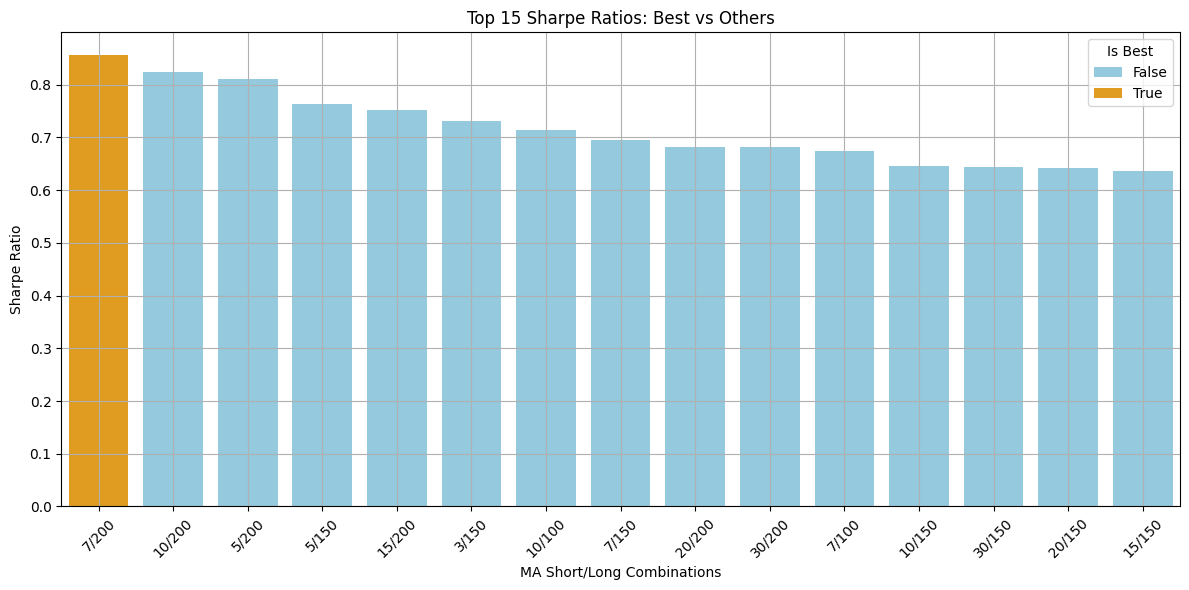

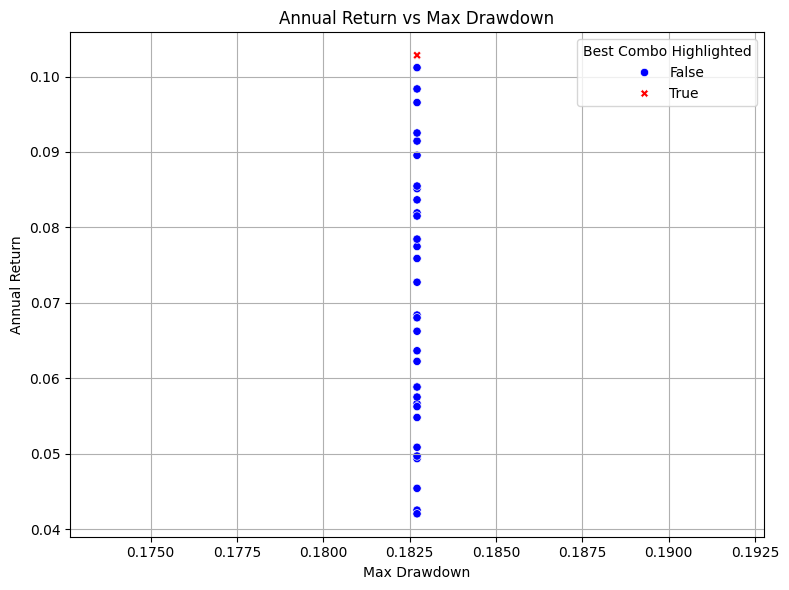

In [11]:

# === Comparing the performance of optimal and non-optimal parameters ===

import seaborn as sns

# === Extracting the optimal parameters ===
best_row = results_df.sort_values('sharpe', ascending=False).iloc[0]
best_short = int(best_row['short'])
best_long = int(best_row['long'])

# === Adding a combination tag ===
results_df['combo'] = results_df['short'].astype(str) + '/' + results_df['long'].astype(str)
results_df['is_best'] = (results_df['short'] == best_short) & (results_df['long'] == best_long)

# === # Visualization: Sharpe comparison (best vs others) ===
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df.sort_values('sharpe', ascending=False).head(15),
            x='combo', y='sharpe', hue='is_best', palette={True: 'orange', False: 'skyblue'})
plt.xticks(rotation=45)
plt.title('Top 15 Sharpe Ratios: Best vs Others')
plt.ylabel('Sharpe Ratio')
plt.xlabel('MA Short/Long Combinations')
plt.legend(title='Is Best')
plt.tight_layout()
plt.grid(True)
plt.show()

# === Visualization: Annualized return vs. maximum drawdown, highlighting the optimal combination ===
plt.figure(figsize=(8,6))
sns.scatterplot(data=results_df, x='max_drawdown', y='ann_return',
                hue='is_best', style='is_best', palette={True: 'red', False: 'blue'})
plt.xlabel('Max Drawdown')
plt.ylabel('Annual Return')
plt.title('Annual Return vs Max Drawdown')
plt.grid(True)
plt.legend(title='Best Combo Highlighted')
plt.tight_layout()
plt.show()

# ATR added only (on the base of optimal parameters)

In [12]:
import pandas as pd
import numpy as np


df = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/SPY_Historical_Data.csv',
    parse_dates=['Date'],
    index_col='Date'
).sort_index()[['Adj Close']]

# === ATR defined and added ===
def compute_atr(df, atr_w):
    """
    True Range and ATR (simple moving average of TR).
    Requires columns: 'High', 'Low', 'Close'.
    """
    high_low        = df['High'] - df['Low']
    high_prev_close = (df['High'] - df['Close'].shift(1)).abs()
    low_prev_close  = (df['Low']  - df['Close'].shift(1)).abs()
    tr = pd.concat([high_low, high_prev_close, low_prev_close], axis=1).max(axis=1)
    atr = tr.rolling(atr_w).mean()
    return atr

def sma_atr(df, short_w=7, long_w=200,
                    atr_w=14, atr_mult=4,
                     fee=0.001):
    data = df.copy()

    for col in ['High','Low','Close']:
        if col not in data:
            data[col] = data['Adj Close']

    data['short_ma'] = data['Adj Close'].rolling(short_w).mean()
    data['long_ma']  = data['Adj Close'].rolling(long_w).mean()
    data['signal']   = (data['short_ma'] > data['long_ma']).astype(int)

    data['atr']  = compute_atr(data, atr_w)
    data['stop'] = data['Adj Close'] - atr_mult * data['atr']
    data['trade']    = data['signal'].diff().fillna(data['signal']).clip(-1,1)
    data['position'] = data['signal'].fillna(0)

    data['strategy_ret'] = data['Adj Close'].pct_change() * data['position'].shift(1)
    data['strategy_ret'] -= abs(data['trade']) * fee



    data['entry_flag']       = np.where(data['trade'] == 1, 1, 0)
    data['entry_id']         = data['entry_flag'].cumsum()
    data['days_since_entry'] = data.groupby('entry_id').cumcount()


    # final returns & equity curve
    data['cum_ret'] = (1 + data['strategy_ret'].fillna(0)).cumprod()


    return data


def performance_stats(res, ret_col='strategy_ret', cum_col='cum_ret'):
    total_return  = res[cum_col].iloc[-1] - 1
    annual_return = np.exp(np.log1p(res[ret_col]).sum()/len(res)*252) - 1
    annual_vol    = res[ret_col].std() * np.sqrt(252)
    sharpe        = annual_return / annual_vol if annual_vol else np.nan
    drawdown      = (res[cum_col].cummax() - res[cum_col]) / res[cum_col].cummax()
    max_dd        = drawdown.max()
    calmar        = annual_return / max_dd if max_dd else np.nan
    return {
        'total_return':   total_return,
        'annual_return':  annual_return,
        'annual_vol':     annual_vol,
        'sharpe':         sharpe,
        'max_drawdown':   max_dd,
        'calmar':         calmar
    }


res = sma_atr(df)
stats = performance_stats(res)

print("Full Performance for SMA + ATR + Dynamic Vol Strategy (short=7, long=200, vol-tgt=15%, min-hold=10, leverage=2):")
for k, v in stats.items():
    print(f"  {k}: {v:.4f}")

Full Performance for SMA + ATR + Dynamic Vol Strategy (short=7, long=200, vol-tgt=15%, min-hold=10, leverage=2):
  total_return: 3.1369
  annual_return: 0.0973
  annual_vol: 0.1169
  sharpe: 0.8319
  max_drawdown: 0.1979
  calmar: 0.4915


# Dynamic added only (on the base of optimal parameters)

In [13]:
import pandas as pd
import numpy as np


df = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/SPY_Historical_Data.csv',
    parse_dates=['Date'],
    index_col='Date'
).sort_index()[['Adj Close']]



def sma_dynamic_vol(df, short_w=7, long_w=200,
                    target_vol=0.08, fee=0.001):
    data = df.copy()

    for col in ['High','Low','Close']:
        if col not in data:
            data[col] = data['Adj Close']

    data['short_ma'] = data['Adj Close'].rolling(short_w).mean()
    data['long_ma']  = data['Adj Close'].rolling(long_w).mean()
    data['signal']   = (data['short_ma'] > data['long_ma']).astype(int)


    data['trade']    = data['signal'].diff().fillna(data['signal']).clip(-1,1)
    data['position'] = data['signal'].fillna(0)

    data['strategy_ret'] = data['Adj Close'].pct_change() * data['position'].shift(1)
    data['strategy_ret'] -= abs(data['trade']) * fee


    data['rolling_vol']      = data['strategy_ret'].shift(1).rolling(20).std() * np.sqrt(252)
    data['leverage']         = (target_vol / data['rolling_vol']).clip(upper=1.0)
    data['leverage'].fillna(0, inplace=True)
    data['strategy_ret_dyn'] = data['strategy_ret'] * data['leverage'].shift(1)




    data['cum_ret_dyn']       = (1 + data['strategy_ret_dyn'].fillna(0)).cumprod()

    return data



def performance_stats(res, ret_col='strategy_ret_dyn', cum_col='cum_ret_dyn'):
    total_return  = res[cum_col].iloc[-1] - 1
    annual_return = np.exp(np.log1p(res[ret_col]).sum()/len(res)*252) - 1
    annual_vol    = res[ret_col].std() * np.sqrt(252)
    sharpe        = annual_return / annual_vol if annual_vol else np.nan
    drawdown      = (res[cum_col].cummax() - res[cum_col]) / res[cum_col].cummax()
    max_dd        = drawdown.max()
    calmar        = annual_return / max_dd if max_dd else np.nan
    return {
        'total_return':   total_return,
        'annual_return':  annual_return,
        'annual_vol':     annual_vol,
        'sharpe':         sharpe,
        'max_drawdown':   max_dd,
        'calmar':         calmar
    }

res = sma_dynamic_vol(df)
stats = performance_stats(res)

print("Full Performance for SMA + ATR + Dynamic Vol Strategy (short=7, long=200, vol-tgt=15%, min-hold=10, leverage=2):")
for k, v in stats.items():
    print(f"  {k}: {v:.4f}")


Full Performance for SMA + ATR + Dynamic Vol Strategy (short=7, long=200, vol-tgt=15%, min-hold=10, leverage=2):
  total_return: 1.5310
  annual_return: 0.0626
  annual_vol: 0.0819
  sharpe: 0.7639
  max_drawdown: 0.1288
  calmar: 0.4860


/tmp/ipython-input-2687948220.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['leverage'].fillna(0, inplace=True)


# ATR+Dynamic(on the base of optimal parameters)

In [14]:
import pandas as pd
import numpy as np


df = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/SPY_Historical_Data.csv',
    parse_dates=['Date'],
    index_col='Date'
).sort_index()[['Adj Close']]


def compute_atr(df, atr_w):
    """
    True Range and ATR (simple moving average of TR).
    Requires columns: 'High', 'Low', 'Close'.
    """
    high_low        = df['High'] - df['Low']
    high_prev_close = (df['High'] - df['Close'].shift(1)).abs()
    low_prev_close  = (df['Low']  - df['Close'].shift(1)).abs()
    tr = pd.concat([high_low, high_prev_close, low_prev_close], axis=1).max(axis=1)
    atr = tr.rolling(atr_w).mean()
    return atr

def sma_atr_dynamic(df, short_w=7, long_w=200,
                    atr_w=14, atr_mult=4,
                    target_vol=0.08, fee=0.001):
    data = df.copy()

    for col in ['High','Low','Close']:
        if col not in data:
            data[col] = data['Adj Close']

    data['short_ma'] = data['Adj Close'].rolling(short_w).mean()
    data['long_ma']  = data['Adj Close'].rolling(long_w).mean()
    data['signal']   = (data['short_ma'] > data['long_ma']).astype(int)

    data['atr']  = compute_atr(data, atr_w)
    data['stop'] = data['Adj Close'] - atr_mult * data['atr']
    data['trade']    = data['signal'].diff().fillna(data['signal']).clip(-1,1)
    data['position'] = data['signal'].fillna(0)

    data['strategy_ret'] = data['Adj Close'].pct_change() * data['position'].shift(1)
    data['strategy_ret'] -= abs(data['trade']) * fee


    data['rolling_vol']      = data['strategy_ret'].shift(1).rolling(atr_w).std() * np.sqrt(252)
    data['leverage']         = (target_vol / data['rolling_vol']).clip(upper=1.0)
    data['leverage'].fillna(0, inplace=True)
    data['strategy_ret_dyn'] = data['strategy_ret'] * data['leverage'].shift(1)

    data['entry_flag']       = np.where(data['trade'] == 1, 1, 0)
    data['entry_id']         = data['entry_flag'].cumsum()
    data['days_since_entry'] = data.groupby('entry_id').cumcount()


    data['strategy_ret_dyn'] = data['Adj Close'].pct_change() * data['position'].shift(1) * data['leverage'].shift(1)
    data['cum_ret_dyn']       = (1 + data['strategy_ret_dyn'].fillna(0)).cumprod()

    return data



def performance_stats(res, ret_col='strategy_ret_dyn', cum_col='cum_ret_dyn'):
    total_return  = res[cum_col].iloc[-1] - 1
    annual_return = np.exp(np.log1p(res[ret_col]).sum()/len(res)*252) - 1
    annual_vol    = res[ret_col].std() * np.sqrt(252)
    sharpe        = annual_return / annual_vol if annual_vol else np.nan
    drawdown      = (res[cum_col].cummax() - res[cum_col]) / res[cum_col].cummax()
    max_dd        = drawdown.max()
    calmar        = annual_return / max_dd if max_dd else np.nan
    return {
        'total_return':   total_return,
        'annual_return':  annual_return,
        'annual_vol':     annual_vol,
        'sharpe':         sharpe,
        'max_drawdown':   max_dd,
        'calmar':         calmar
    }


res_old = sma_atr_dynamic(df)
stats = performance_stats(res_old)

print("Full Performance for SMA + ATR + Dynamic Vol Strategy (short=7, long=200, vol-tgt=15%, min-hold=10, leverage=2):")
for k, v in stats.items():
    print(f"  {k}: {v:.4f}")

Full Performance for SMA + ATR + Dynamic Vol Strategy (short=7, long=200, vol-tgt=15%, min-hold=10, leverage=2):
  total_return: 1.4690
  annual_return: 0.0609
  annual_vol: 0.0817
  sharpe: 0.7446
  max_drawdown: 0.1439
  calmar: 0.4231


/tmp/ipython-input-2669092274.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['leverage'].fillna(0, inplace=True)


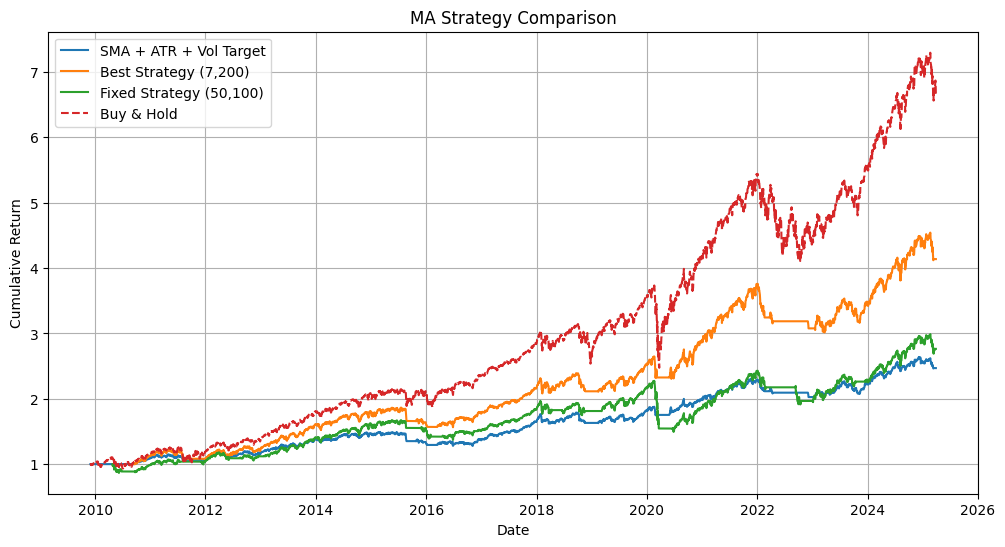

In [15]:
# visualization since the result is not bad
plt.figure(figsize=(12,6))
plt.plot(res_old.index, res_old['cum_ret_dyn'], label='SMA + ATR + Vol Target')
plt.plot(best_result.index, best_result['cum_ret'], label=f'Best Strategy ({best_short},{best_long})')
plt.plot(fixed_result.index, fixed_result['cum_ret'], label='Fixed Strategy (50,100)')
plt.plot(df.index, df['Adj Close'] / df['Adj Close'].iloc[0], '--', label='Buy & Hold')
plt.title('MA Strategy Comparison')
plt.xlabel('Date'); plt.ylabel('Cumulative Return')
plt.legend(); plt.grid(); plt.show()

# ATR + Dynamic + deadband
（deadband didn't give any improvement, so didn't be written in the report）

In [16]:
import pandas as pd
import numpy as np


df = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/SPY_Historical_Data.csv',
    parse_dates=['Date'],
    index_col='Date'
).sort_index()[['Adj Close']]


def compute_atr(df, atr_w):
    """
    True Range and ATR (simple moving average of TR).
    Requires columns: 'High', 'Low', 'Close'.
    """
    high_low        = df['High'] - df['Low']
    high_prev_close = (df['High'] - df['Close'].shift(1)).abs()
    low_prev_close  = (df['Low']  - df['Close'].shift(1)).abs()
    tr = pd.concat([high_low, high_prev_close, low_prev_close], axis=1).max(axis=1)
    atr = tr.rolling(atr_w).mean()
    return atr

def sma_atr_dynamic(df, short_w=7, long_w=200,
                    atr_w=14, atr_mult=4,
                    deadband=0.001,
                    target_vol=0.08, fee=0.001):
    data = df.copy()

    for col in ['High','Low','Close']:
        if col not in data:
            data[col] = data['Adj Close']

    data['short_ma'] = data['Adj Close'].rolling(short_w).mean()
    data['long_ma']  = data['Adj Close'].rolling(long_w).mean()
    db_mask = (data['short_ma'] / data['long_ma'] - 1) > deadband
    data['signal'] = np.where((data['short_ma'] > data['long_ma']) & db_mask, 1, 0).astype(int)



    data['atr']  = compute_atr(data, atr_w)
    data['stop'] = data['Adj Close'] - atr_mult * data['atr']
    data['trade']    = data['signal'].diff().fillna(data['signal']).clip(-1,1)
    data['position'] = data['signal'].fillna(0)

    data['strategy_ret'] = data['Adj Close'].pct_change() * data['position'].shift(1)
    data['strategy_ret'] -= abs(data['trade']) * fee


    data['rolling_vol']      = data['strategy_ret'].shift(1).rolling(atr_w).std() * np.sqrt(252)
    data['leverage']         = (target_vol / data['rolling_vol']).clip(upper=1.0)
    data['leverage'].fillna(0, inplace=True)
    data['strategy_ret_dyn'] = data['strategy_ret'] * data['leverage'].shift(1)

    data['entry_flag']       = np.where(data['trade'] == 1, 1, 0)
    data['entry_id']         = data['entry_flag'].cumsum()
    data['days_since_entry'] = data.groupby('entry_id').cumcount()



    data['strategy_ret_dyn'] = data['Adj Close'].pct_change() * data['position'].shift(1) * data['leverage'].shift(1)
    data['cum_ret_dyn']       = (1 + data['strategy_ret_dyn'].fillna(0)).cumprod()

    return data



def performance_stats(res, ret_col='strategy_ret_dyn', cum_col='cum_ret_dyn'):
    total_return  = res[cum_col].iloc[-1] - 1
    annual_return = np.exp(np.log1p(res[ret_col]).sum()/len(res)*252) - 1
    annual_vol    = res[ret_col].std() * np.sqrt(252)
    sharpe        = annual_return / annual_vol if annual_vol else np.nan
    drawdown      = (res[cum_col].cummax() - res[cum_col]) / res[cum_col].cummax()
    max_dd        = drawdown.max()
    calmar        = annual_return / max_dd if max_dd else np.nan
    return {
        'total_return':   total_return,
        'annual_return':  annual_return,
        'annual_vol':     annual_vol,
        'sharpe':         sharpe,
        'max_drawdown':   max_dd,
        'calmar':         calmar
    }


res_new = sma_atr_dynamic(df)
stats = performance_stats(res_new)

print("Full Performance for SMA + ATR + Dynamic Vol Strategy (short=7, long=200, vol-tgt=15%, min-hold=10, leverage=2):")
for k, v in stats.items():
    print(f"  {k}: {v:.4f}")

Full Performance for SMA + ATR + Dynamic Vol Strategy (short=7, long=200, vol-tgt=15%, min-hold=10, leverage=2):
  total_return: 1.4649
  annual_return: 0.0607
  annual_vol: 0.0816
  sharpe: 0.7440
  max_drawdown: 0.1438
  calmar: 0.4225


/tmp/ipython-input-4179736979.py:52: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['leverage'].fillna(0, inplace=True)


# MA(7,200)+minimum hold 10 days+ 2xleverage

Performance for SMA(50,100) + MinHold(10d) + 2x Leverage:
  total_return: 4.9662
  annual_return: 0.1273
  annual_vol: 0.2679
  sharpe: 0.4752
  max_drawdown: 0.5951
  calmar: 0.2139


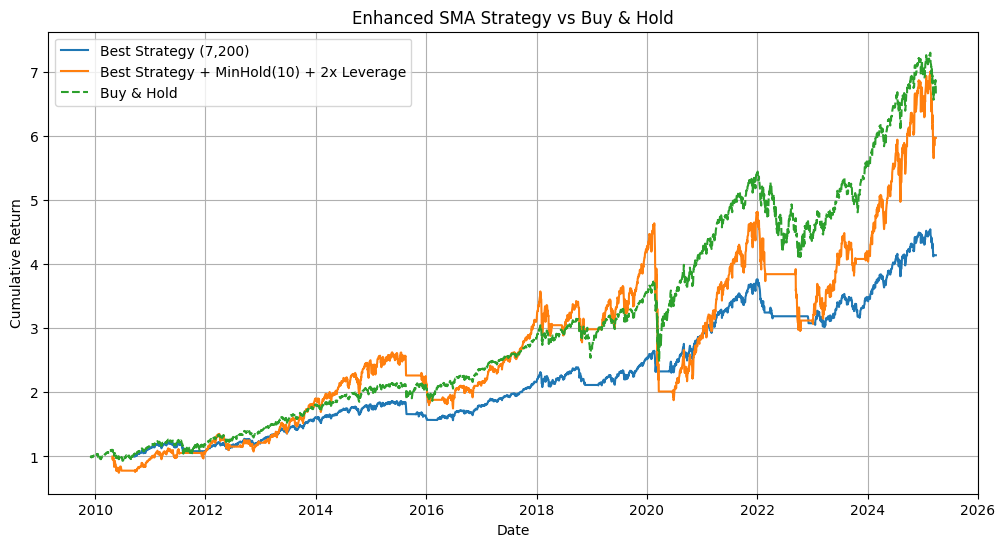

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SPY_Historical_Data.csv', parse_dates=['Date'], index_col='Date').sort_index()
df = df[['Adj Close']]


def sma_with_min_hold_and_leverage(df, short_w=50, long_w=100, fee=0.001, min_hold=10, leverage=2.0):
    data = df.copy()
    data['short_ma'] = data['Adj Close'].rolling(short_w).mean()
    data['long_ma']  = data['Adj Close'].rolling(long_w).mean()
    data['signal']   = (data['short_ma'] > data['long_ma']).astype(int)
    data['trade']    = data['signal'].diff().fillna(data['signal']).clip(-1,1)

    # Initialize the position status and holding days
    data['position'] = 0
    holding_days = 0

    for i in range(1, len(data)):
        if data['trade'].iat[i] == 1:
            # New entry, reset the holding days
            data.iat[i, data.columns.get_loc('position')] = 1
            holding_days = 1
        elif data['position'].iat[i-1] == 1:
            holding_days += 1
            # If it is less than the minimum holding period, it is forced to hold
            if data['signal'].iat[i] == 0 and holding_days < min_hold:
                data.iat[i, data.columns.get_loc('position')] = 1
                data.iat[i, data.columns.get_loc('trade')] = 0
            elif data['signal'].iat[i] == 0 and holding_days >= min_hold:
                data.iat[i, data.columns.get_loc('position')] = 0
                holding_days = 0
            else:
                data.iat[i, data.columns.get_loc('position')] = 1
        else:
            data.iat[i, data.columns.get_loc('position')] = 0


    data['ret'] = data['Adj Close'].pct_change() * data['position'].shift(1) * leverage
    data['ret'] -= abs(data['trade']) * fee
    data.dropna(inplace=True)
    data['cum_ret'] = (1 + data['ret']).cumprod()
    return data


res = sma_with_min_hold_and_leverage(df, short_w=50, long_w=100)


def performance_stats(res):
    total_return = res['cum_ret'].iloc[-1] - 1
    annual_return = np.exp(np.log1p(res['ret']).sum()/len(res) * 252) - 1
    annual_vol = res['ret'].std() * np.sqrt(252)
    sharpe = annual_return / annual_vol if annual_vol else np.nan
    drawdown = (res['cum_ret'].cummax() - res['cum_ret']) / res['cum_ret'].cummax()
    max_dd = drawdown.max()
    calmar = annual_return / max_dd if max_dd else np.nan
    return {
        'total_return': total_return,
        'annual_return': annual_return,
        'annual_vol': annual_vol,
        'sharpe': sharpe,
        'max_drawdown': max_dd,
        'calmar': calmar
    }


stats = performance_stats(res)
print("Performance for SMA(50,100) + MinHold(10d) + 2x Leverage:")
for k, v in stats.items():
    print(f"  {k}: {v:.4f}")


plt.figure(figsize=(12,6))
plt.plot(best_result.index, best_result['cum_ret'], label=f'Best Strategy ({best_short},{best_long})')
plt.plot(res.index, res['cum_ret'], label='Best Strategy + MinHold(10) + 2x Leverage')
plt.plot(df.index, df['Adj Close'] / df['Adj Close'].iloc[0], '--', label='Buy & Hold')
plt.legend()
plt.title('Enhanced SMA Strategy vs Buy & Hold')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()

# ATR + Dynamic + minimum hold 10 days

In [18]:
import pandas as pd
import numpy as np


df = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/SPY_Historical_Data.csv',
    parse_dates=['Date'],
    index_col='Date'
).sort_index()[['Adj Close']]


def compute_atr(df, atr_w):
    """
    True Range and ATR (simple moving average of TR).
    Requires columns: 'High', 'Low', 'Close'.
    """
    high_low        = df['High'] - df['Low']
    high_prev_close = (df['High'] - df['Close'].shift(1)).abs()
    low_prev_close  = (df['Low']  - df['Close'].shift(1)).abs()
    tr = pd.concat([high_low, high_prev_close, low_prev_close], axis=1).max(axis=1)
    atr = tr.rolling(atr_w).mean()
    return atr

def sma_atr_dynamic(df, short_w=7, long_w=200,
                    atr_w=14, atr_mult=4,
                    target_vol=0.08, fee=0.001, min_hold=10):
    data = df.copy()

    for col in ['High','Low','Close']:
        if col not in data:
            data[col] = data['Adj Close']

    data['short_ma'] = data['Adj Close'].rolling(short_w).mean()
    data['long_ma']  = data['Adj Close'].rolling(long_w).mean()
    data['signal']   = (data['short_ma'] > data['long_ma']).astype(int)

    data['atr']  = compute_atr(data, atr_w)
    data['stop'] = data['Adj Close'] - atr_mult * data['atr']
    data['trade']    = data['signal'].diff().fillna(data['signal']).clip(-1,1)
    data['position'] = data['signal'].fillna(0)

    data['strategy_ret'] = data['Adj Close'].pct_change() * data['position'].shift(1)
    data['strategy_ret'] -= abs(data['trade']) * fee


    data['rolling_vol']      = data['strategy_ret'].shift(1).rolling(atr_w).std() * np.sqrt(252)
    data['leverage']         = (target_vol / data['rolling_vol']).clip(upper=1.0)
    data['leverage'].fillna(0, inplace=True)
    data['strategy_ret_dyn'] = data['strategy_ret'] * data['leverage'].shift(1)

    data['entry_flag']       = np.where(data['trade'] == 1, 1, 0)
    data['entry_id']         = data['entry_flag'].cumsum()
    data['days_since_entry'] = data.groupby('entry_id').cumcount()

    # block any exit before min_hold days
    exit_signal = (data['trade'] == -1) & (data['days_since_entry'] < min_hold)
    # cancel those premature exits
    data.loc[exit_signal, 'trade']    = 0
    # rebuild position after blocking exits
    data['position'] = data['trade'].cumsum().clip(0,1)

    # 7) final returns & equity curve
    data['strategy_ret_dyn'] = data['Adj Close'].pct_change() * data['position'].shift(1) * data['leverage'].shift(1)
    data['cum_ret_dyn']       = (1 + data['strategy_ret_dyn'].fillna(0)).cumprod()

    return data



def performance_stats(res, ret_col='strategy_ret_dyn', cum_col='cum_ret_dyn'):
    total_return  = res[cum_col].iloc[-1] - 1
    annual_return = np.exp(np.log1p(res[ret_col]).sum()/len(res)*252) - 1
    annual_vol    = res[ret_col].std() * np.sqrt(252)
    sharpe        = annual_return / annual_vol if annual_vol else np.nan
    drawdown      = (res[cum_col].cummax() - res[cum_col]) / res[cum_col].cummax()
    max_dd        = drawdown.max()
    calmar        = annual_return / max_dd if max_dd else np.nan
    return {
        'total_return':   total_return,
        'annual_return':  annual_return,
        'annual_vol':     annual_vol,
        'sharpe':         sharpe,
        'max_drawdown':   max_dd,
        'calmar':         calmar
    }


res = sma_atr_dynamic(df)
stats = performance_stats(res)

print("Full Performance for SMA + ATR + Dynamic Vol Strategy (short=7, long=200, vol-tgt=15%, min-hold=10, leverage=2):")
for k, v in stats.items():
    print(f"  {k}: {v:.4f}")

Full Performance for SMA + ATR + Dynamic Vol Strategy (short=7, long=200, vol-tgt=15%, min-hold=10, leverage=2):
  total_return: 2.3002
  annual_return: 0.0812
  annual_vol: 0.1117
  sharpe: 0.7267
  max_drawdown: 0.1992
  calmar: 0.4076


/tmp/ipython-input-2382730890.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['leverage'].fillna(0, inplace=True)


# ATR + Dynamic vol=15% (previous vol=8%)

In [19]:
import pandas as pd
import numpy as np


df = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/SPY_Historical_Data.csv',
    parse_dates=['Date'],
    index_col='Date'
).sort_index()[['Adj Close']]


def compute_atr(df, atr_w):
    """
    True Range and ATR (simple moving average of TR).
    Requires columns: 'High', 'Low', 'Close'.
    """
    high_low        = df['High'] - df['Low']
    high_prev_close = (df['High'] - df['Close'].shift(1)).abs()
    low_prev_close  = (df['Low']  - df['Close'].shift(1)).abs()
    tr = pd.concat([high_low, high_prev_close, low_prev_close], axis=1).max(axis=1)
    atr = tr.rolling(atr_w).mean()
    return atr

def sma_atr_dynamic(df, short_w=7, long_w=200,
                    atr_w=14, atr_mult=4,
                    target_vol=0.15, fee=0.001):
    data = df.copy()

    for col in ['High','Low','Close']:
        if col not in data:
            data[col] = data['Adj Close']

    data['short_ma'] = data['Adj Close'].rolling(short_w).mean()
    data['long_ma']  = data['Adj Close'].rolling(long_w).mean()
    data['signal']   = (data['short_ma'] > data['long_ma']).astype(int)

    data['atr']  = compute_atr(data, atr_w)
    data['stop'] = data['Adj Close'] - atr_mult * data['atr']
    data['trade']    = data['signal'].diff().fillna(data['signal']).clip(-1,1)
    data['position'] = data['signal'].fillna(0)

    data['strategy_ret'] = data['Adj Close'].pct_change() * data['position'].shift(1)
    data['strategy_ret'] -= abs(data['trade']) * fee


    data['rolling_vol']      = data['strategy_ret'].shift(1).rolling(atr_w).std() * np.sqrt(252)
    data['leverage']         = (target_vol / data['rolling_vol']).clip(upper=1.0)
    data['leverage'].fillna(0, inplace=True)
    data['strategy_ret_dyn'] = data['strategy_ret'] * data['leverage'].shift(1)

    data['entry_flag']       = np.where(data['trade'] == 1, 1, 0)
    data['entry_id']         = data['entry_flag'].cumsum()
    data['days_since_entry'] = data.groupby('entry_id').cumcount()


    data['strategy_ret_dyn'] = data['Adj Close'].pct_change() * data['position'].shift(1) * data['leverage'].shift(1)
    data['cum_ret_dyn']       = (1 + data['strategy_ret_dyn'].fillna(0)).cumprod()

    return data



def performance_stats(res, ret_col='strategy_ret_dyn', cum_col='cum_ret_dyn'):
    total_return  = res[cum_col].iloc[-1] - 1
    annual_return = np.exp(np.log1p(res[ret_col]).sum()/len(res)*252) - 1
    annual_vol    = res[ret_col].std() * np.sqrt(252)
    sharpe        = annual_return / annual_vol if annual_vol else np.nan
    drawdown      = (res[cum_col].cummax() - res[cum_col]) / res[cum_col].cummax()
    max_dd        = drawdown.max()
    calmar        = annual_return / max_dd if max_dd else np.nan
    return {
        'total_return':   total_return,
        'annual_return':  annual_return,
        'annual_vol':     annual_vol,
        'sharpe':         sharpe,
        'max_drawdown':   max_dd,
        'calmar':         calmar
    }


res = sma_atr_dynamic(df)
stats = performance_stats(res)

print("Full Performance for SMA + ATR + Dynamic Vol Strategy (short=7, long=200, vol-tgt=15%, min-hold=10, leverage=2):")
for k, v in stats.items():
    print(f"  {k}: {v:.4f}")

Full Performance for SMA + ATR + Dynamic Vol Strategy (short=7, long=200, vol-tgt=15%, min-hold=10, leverage=2):
  total_return: 2.7432
  annual_return: 0.0901
  annual_vol: 0.1091
  sharpe: 0.8256
  max_drawdown: 0.1776
  calmar: 0.5074


/tmp/ipython-input-2952079730.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['leverage'].fillna(0, inplace=True)


# ATR + Dynamic lev=2.0 (previous lev=1)

---



In [21]:
import pandas as pd
import numpy as np


df = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/SPY_Historical_Data.csv',
    parse_dates=['Date'],
    index_col='Date'
).sort_index()[['Adj Close']]


def compute_atr(df, atr_w):
    """
    True Range and ATR (simple moving average of TR).
    Requires columns: 'High', 'Low', 'Close'.
    """
    high_low        = df['High'] - df['Low']
    high_prev_close = (df['High'] - df['Close'].shift(1)).abs()
    low_prev_close  = (df['Low']  - df['Close'].shift(1)).abs()
    tr = pd.concat([high_low, high_prev_close, low_prev_close], axis=1).max(axis=1)
    atr = tr.rolling(atr_w).mean()
    return atr

def sma_atr_dynamic(df, short_w=7, long_w=200,
                    atr_w=14, atr_mult=4,
                    target_vol=0.08, fee=0.001):
    data = df.copy()

    for col in ['High','Low','Close']:
        if col not in data:
            data[col] = data['Adj Close']

    data['short_ma'] = data['Adj Close'].rolling(short_w).mean()
    data['long_ma']  = data['Adj Close'].rolling(long_w).mean()
    data['signal']   = (data['short_ma'] > data['long_ma']).astype(int)

    data['atr']  = compute_atr(data, atr_w)
    data['stop'] = data['Adj Close'] - atr_mult * data['atr']
    data['trade']    = data['signal'].diff().fillna(data['signal']).clip(-1,1)
    data['position'] = data['signal'].fillna(0)

    data['strategy_ret'] = data['Adj Close'].pct_change() * data['position'].shift(1)
    data['strategy_ret'] -= abs(data['trade']) * fee


    data['rolling_vol']      = data['strategy_ret'].shift(1).rolling(atr_w).std() * np.sqrt(252)
    data['leverage']         = (target_vol / data['rolling_vol']).clip(upper=2.0)
    data['leverage'].fillna(0, inplace=True)
    data['strategy_ret_dyn'] = data['strategy_ret'] * data['leverage'].shift(1)

    data['entry_flag']       = np.where(data['trade'] == 1, 1, 0)
    data['entry_id']         = data['entry_flag'].cumsum()
    data['days_since_entry'] = data.groupby('entry_id').cumcount()



    data['strategy_ret_dyn'] = data['Adj Close'].pct_change() * data['position'].shift(1) * data['leverage'].shift(1)
    data['cum_ret_dyn']       = (1 + data['strategy_ret_dyn'].fillna(0)).cumprod()

    return data


def performance_stats(res, ret_col='strategy_ret_dyn', cum_col='cum_ret_dyn'):
    total_return  = res[cum_col].iloc[-1] - 1
    annual_return = np.exp(np.log1p(res[ret_col]).sum()/len(res)*252) - 1
    annual_vol    = res[ret_col].std() * np.sqrt(252)
    sharpe        = annual_return / annual_vol if annual_vol else np.nan
    drawdown      = (res[cum_col].cummax() - res[cum_col]) / res[cum_col].cummax()
    max_dd        = drawdown.max()
    calmar        = annual_return / max_dd if max_dd else np.nan
    return {
        'total_return':   total_return,
        'annual_return':  annual_return,
        'annual_vol':     annual_vol,
        'sharpe':         sharpe,
        'max_drawdown':   max_dd,
        'calmar':         calmar
    }

res = sma_atr_dynamic(df)
stats = performance_stats(res)

print("Full Performance for SMA + ATR + Dynamic Vol Strategy (short=7, long=200, vol-tgt=15%, min-hold=10, leverage=2):")
for k, v in stats.items():
    print(f"  {k}: {v:.4f}")

Full Performance for SMA + ATR + Dynamic Vol Strategy (short=7, long=200, vol-tgt=15%, min-hold=10, leverage=2):
  total_return: 1.8803
  annual_return: 0.0716
  annual_vol: 0.0919
  sharpe: 0.7790
  max_drawdown: 0.1524
  calmar: 0.4697


/tmp/ipython-input-1198293429.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['leverage'].fillna(0, inplace=True)


## ATR + minimum hold 10 days + lev=2 + vol=15%

In [22]:
import pandas as pd
import numpy as np


df = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/SPY_Historical_Data.csv',
    parse_dates=['Date'],
    index_col='Date'
).sort_index()[['Adj Close']]


def compute_atr(df, atr_w):
    """
    True Range and ATR (simple moving average of TR).
    Requires columns: 'High', 'Low', 'Close'.
    """
    high_low        = df['High'] - df['Low']
    high_prev_close = (df['High'] - df['Close'].shift(1)).abs()
    low_prev_close  = (df['Low']  - df['Close'].shift(1)).abs()
    tr = pd.concat([high_low, high_prev_close, low_prev_close], axis=1).max(axis=1)
    atr = tr.rolling(atr_w).mean()
    return atr

def sma_atr_dynamic(df, short_w=7, long_w=200,
                    atr_w=14, atr_mult=4,
                    target_vol=0.15, fee=0.001, min_hold=10):
    data = df.copy()

    for col in ['High','Low','Close']:
        if col not in data:
            data[col] = data['Adj Close']

    data['short_ma'] = data['Adj Close'].rolling(short_w).mean()
    data['long_ma']  = data['Adj Close'].rolling(long_w).mean()
    data['signal']   = (data['short_ma'] > data['long_ma']).astype(int)

    data['atr']  = compute_atr(data, atr_w)
    data['stop'] = data['Adj Close'] - atr_mult * data['atr']
    data['trade']    = data['signal'].diff().fillna(data['signal']).clip(-1,1)
    data['position'] = data['signal'].fillna(0)

    data['strategy_ret'] = data['Adj Close'].pct_change() * data['position'].shift(1)
    data['strategy_ret'] -= abs(data['trade']) * fee


    data['rolling_vol']      = data['strategy_ret'].shift(1).rolling(atr_w).std() * np.sqrt(252)
    data['leverage']         = (target_vol / data['rolling_vol']).clip(upper=2.0)
    data['leverage'].fillna(0, inplace=True)
    data['strategy_ret_dyn'] = data['strategy_ret'] * data['leverage'].shift(1)

    data['entry_flag']       = np.where(data['trade'] == 1, 1, 0)
    data['entry_id']         = data['entry_flag'].cumsum()
    data['days_since_entry'] = data.groupby('entry_id').cumcount()

    # block any exit before min_hold days
    exit_signal = (data['trade'] == -1) & (data['days_since_entry'] < min_hold)
    # cancel those premature exits
    data.loc[exit_signal, 'trade']    = 0
    # rebuild position after blocking exits
    data['position'] = data['trade'].cumsum().clip(0,1)

    # 7) final returns & equity curve
    data['strategy_ret_dyn'] = data['Adj Close'].pct_change() * data['position'].shift(1) * data['leverage'].shift(1)
    data['cum_ret_dyn']       = (1 + data['strategy_ret_dyn'].fillna(0)).cumprod()

    return data



def performance_stats(res, ret_col='strategy_ret_dyn', cum_col='cum_ret_dyn'):
    total_return  = res[cum_col].iloc[-1] - 1
    annual_return = np.exp(np.log1p(res[ret_col]).sum()/len(res)*252) - 1
    annual_vol    = res[ret_col].std() * np.sqrt(252)
    sharpe        = annual_return / annual_vol if annual_vol else np.nan
    drawdown      = (res[cum_col].cummax() - res[cum_col]) / res[cum_col].cummax()
    max_dd        = drawdown.max()
    calmar        = annual_return / max_dd if max_dd else np.nan
    return {
        'total_return':   total_return,
        'annual_return':  annual_return,
        'annual_vol':     annual_vol,
        'sharpe':         sharpe,
        'max_drawdown':   max_dd,
        'calmar':         calmar
    }


res_new = sma_atr_dynamic(df)
stats = performance_stats(res_new)

print("Full Performance for SMA + ATR + Dynamic Vol Strategy (short=7, long=200, vol-tgt=15%, min-hold=10, leverage=2):")
for k, v in stats.items():
    print(f"  {k}: {v:.4f}")

Full Performance for SMA + ATR + Dynamic Vol Strategy (short=7, long=200, vol-tgt=15%, min-hold=10, leverage=2):
  total_return: 7.3883
  annual_return: 0.1492
  annual_vol: 0.2174
  sharpe: 0.6861
  max_drawdown: 0.3746
  calmar: 0.3982


/tmp/ipython-input-2137064895.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['leverage'].fillna(0, inplace=True)


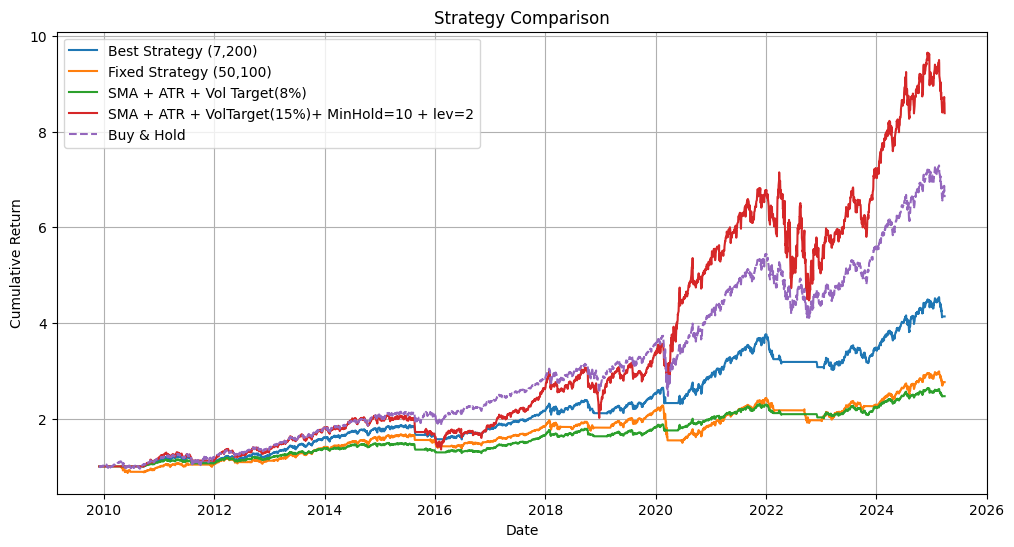

In [23]:


plt.figure(figsize=(12,6))
plt.plot(best_result.index, best_result['cum_ret'], label=f'Best Strategy ({best_short},{best_long})')
plt.plot(fixed_result.index, fixed_result['cum_ret'], label='Fixed Strategy (50,100)')
plt.plot(res_old.index, res_old['cum_ret_dyn'], label='SMA + ATR + Vol Target(8%)')
plt.plot(res_new.index, res_new['cum_ret_dyn'], label='SMA + ATR + VolTarget(15%)+ MinHold=10 + lev=2')
plt.plot(df.index, df['Adj Close']/df['Adj Close'].iloc[0], '--', label='Buy & Hold')
plt.title('Strategy Comparison')
plt.xlabel('Date'); plt.ylabel('Cumulative Return')
plt.legend(); plt.grid(); plt.show()
